In [7]:
import os
import pandas as pd
from zipline import run_algorithm
from zipline.api import (
    date_rules,
    order_target_percent,
    schedule_function,
    symbol,
    time_rules,
)

from zipline.data import bundles
from zipline.finance import commission, slippage

In [8]:
# Set the QUANDL API key.
# NOTE: Always keep API keys private. Consider using 
# environment variables or other secure methods.
os.environ["QUANDL_API_KEY"] = "j8nJ7FtfX3vGX4hCiUdm"

# Ingest data from Quandl to be used with Zipline.
bundles.ingest("quandl")

C:\Users\chadc\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:106: FutureWarning: The provided callable <function amin at 0x00000186B81D3790> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
C:\Users\chadc\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bundles\quandl.py:106: FutureWarning: The provided callable <function amax at 0x00000186B81D35E0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data = data.groupby(by="symbol").agg({"date": [np.min, np.max]})
C:\Users\chadc\anaconda3\envs\quant-stack\lib\site-packages\zipline\data\bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
            

In [27]:
def initialize(context):
    """
    Set up the initial values and settings for the trading algorithm.
    Called once at the start of the algorithm.
    """
    # List of ETFs that the algorithm will consider for trading.
    context.symbols = [
        symbol("FB"),
        symbol("AAPL"),
        symbol("AMZN"),
        symbol("NFLX"),
        symbol("GOOG"),
    ]

    # Number of top-performing assets to trade each month.
    context.traded_count = 3

    # Lookback period: Number of days the algorithm will use to calculate momentum.
    # (12 months * approx. 21 trading days per month)
    context.lookback = 12 * 21

    # Define the model for trading costs.
    context.set_commission(commission.PerShare(cost=0.007, min_trade_cost=1.0))
    
    # Define the slippage model.
    context.set_slippage(slippage.VolumeShareSlippage())

    # Schedule a function to rebalance the portfolio at the start of each 
    # month when the market opens.
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())


In [28]:
def rebalance(context, data):
    """
    Execute orders according to our scheduled timing.
    """
    # Fetching historical price data
    hist = data.history(context.symbols, "close", context.lookback, "1d")
    # Calculating momentum for each ETF
    momentum = hist.pct_change().mean()
    # Sorting ETFs by momentum
    sorted_by_momentum = momentum.sort_values(ascending=False)
    # Selecting the top 3 ETFs
    selected_assets = sorted_by_momentum.index[: context.traded_count]
    # Liquidating all positions not in the top 3
    for asset in context.portfolio.positions:
        if asset.symbol not in selected_assets:
            order_target_percent(asset, 0)
    # Placing orders for the top 3 ETFs
    for asset in selected_assets:
        order_target_percent(asset, 1 / context.traded_count)

In [37]:
# Defining our backtest period
start = pd.Timestamp("2010-01-01")
end = pd.Timestamp("2018-12-31")

In [38]:
# Running the backtest
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,
    bundle="quandl",
)

C:\Users\chadc\AppData\Local\Temp\tmpyrl36qrf\ipykernel_11452\347881908.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum = hist.pct_change().mean()
C:\Users\chadc\anaconda3\envs\quant-stack\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
Cannot place order for NFLX, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-03-28 00:00:00.
Cannot place order for AMZN, as it has de-listed. Any existing positions for this asset will be liquidated on 2018-03

In [39]:
perf.to_pickle("strat_perf.pickle")

<Axes: >

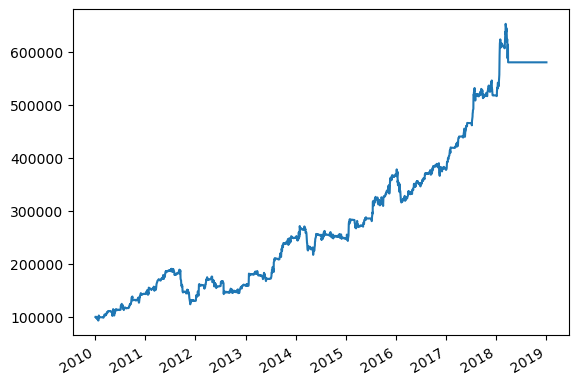

In [40]:
perf.portfolio_value.plot()